<a href="https://colab.research.google.com/github/DexterfreaK/XGboostUrban/blob/master/XGBoost_using_dataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install gdal

In [ ]:
from osgeo import gdal
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor


In [ ]:
# All features in X imported and read as Array
popden = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/popden.tif")
popden = popden.ReadAsArray()

Slope = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/slope.tif")
Slope = Slope.ReadAsArray()

Friction = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/friction.tif")
Friction = Friction.ReadAsArray()

Elevation = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/elevation.tif")
Elevation = Elevation.ReadAsArray()


gdp2005 = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/gdp2005.tif")
gdp2005 = gdp2005.ReadAsArray()

floods = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/floods.tif")
floods = floods.ReadAsArray()

accessibility = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/accessibility.tif")
accessibility = accessibility.ReadAsArray()

builtup_05_06 = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/05_06_builtup.tif")
builtup_05_06 = builtup_05_06.ReadAsArray()

# Required Shape checking for All features
assert Slope.shape == popden.shape == Friction.shape == Elevation.shape == gdp2005.shape == floods.shape == accessibility.shape == builtup_05_06.shape

(l,w) = Slope.shape

# Reshaping the image to be a 1d Array
Slope = np.reshape(Slope, (l*w,1))
popden = np.reshape(popden, (l*w,1))
Friction = np.reshape(Friction, (l*w,1))
Elevation = np.reshape(Elevation, (l*w,1))
floods = np.reshape(floods, (l*w,1))
accessibility = np.reshape(accessibility, (l*w,1))
builtup_05_06 = np.reshape(builtup_05_06, (l*w,1))
gdp2005 = np.reshape(gdp2005, (l*w,1))


In [ ]:
#Opening and Reading Y data
Subtracted_builtup_05_06_gdal_data = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/Difference_Builtup_11_05.tif")
Subtracted_builtup_05_06 = Subtracted_builtup_05_06_gdal_data.ReadAsArray()

assert Subtracted_builtup_05_06.shape == (l,w)

#Opening and Reshaping the data
Subtracted_builtup_05_06 = np.reshape(Subtracted_builtup_05_06, (l*w,1))

In [ ]:
# Converting the array data to dataframe for both X and Y
df = pd.DataFrame({
    'Slope': Slope.flatten(),
    'Elevation': Elevation.flatten(),
    'PopDen': popden.flatten(),
    'Friction': Friction.flatten(),
    'Floods': floods.flatten(),
    'Accessibility': accessibility.flatten(),
    'Gdp2005': gdp2005.flatten(),
    'builtup_05_06': builtup_05_06.flatten(),
    'Y_Subtracted_builtup_11_05': Subtracted_builtup_05_06.flatten(),
})


In [ ]:
df.describe()

,Slope,Elevation,PopDen,Friction,Floods,Accessibility,Gdp2005,builtup_05_06,Y_Subtracted_builtup_11_05
count,3.331200e+06,3.331200e+06,3.256383e+06,3.331200e+06,3.331200e+06,3.331200e+06,2.002123e+06,3.331200e+06,3.331200e+06
mean,NaN,-inf,7.454635e-02,-inf,-inf,-inf,1.777354e-01,7.026747e-02,9.279239e-03
std,inf,inf,1.540960e-01,inf,inf,inf,2.715401e-01,2.555973e-01,9.588085e-02
min,-3.402823e+38,-3.402823e+38,0.000000e+00,-3.402823e+38,-3.402823e+38,-3.402823e+38,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.433329e-01,8.701493e-01,0.000000e+00,8.396575e-01,-3.402823e+38,7.584229e-01,1.772051e-02,0.000000e+00,0.000000e+00
50%,9.840268e-01,9.253731e-01,0.000000e+00,9.809301e-01,3.482746e-01,9.119344e-01,4.634973e-02,0.000000e+00,0.000000e+00
75%,1.000000e+00,1.000000e+00,8.384361e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.996024e-01,0.000000e+00,0.000000e+00
max,3.400000e+38,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
# dropping Y from X
X = df.drop('Y_Subtracted_builtup_11_05', axis=1)
Y = df['Y_Subtracted_builtup_11_05']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, train_size = .80)

In [ ]:
params = {
            'max_depth': 6,
            'learning_rate': .3,
        }

xgb_model=XGBClassifier(**params)
model=xgb_model.fit(X_train,y_train)

In [ ]:
# Predicting the Test set results
y_pred = model.predict(X_test)

Import some metrics and checking models' score

In [ ]:
#Import some metrics.
from sklearn.metrics import precision_score, recall_score, accuracy_score
print("Type = {}".format(type(model)))
print("Precision = {}".format(precision_score(y_test, y_pred, average='macro')))
print("Recall = {}".format(recall_score(y_test, y_pred, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, y_pred)))


Type = <class 'xgboost.sklearn.XGBClassifier'>
Precision = 0.8681742309646596
Recall = 0.7213101024758528
Accuracy = 0.993313220461095


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

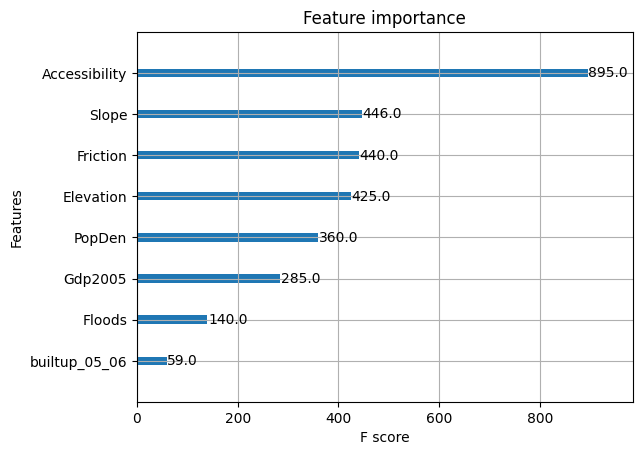

In [ ]:
from xgboost import plot_importance
plot_importance(xgb_model)

Select parameters with `GridSearch`

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
     "n_estimators"     : [10, 20, 30]
     }

grid = GridSearchCV(clf, parameters, n_jobs=4, cv=3)

In [ ]:
grid.fit(X_train, y_train)

**Prediction of the Urbanised Map**

In [ ]:
y_pred = model.predict(X)
y_pred = np.reshape(y_pred,(l,w)).astype(np.float32)

Converting predicted array to tiff image

In [ ]:
def write_geotiff(filename, arr, in_ds):
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32

    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    band = out_ds.GetRasterBand(1)
    band.WriteArray(arr)
    band.FlushCache()
    band.ComputeStatistics(False)

In [ ]:
write_geotiff('Predicted_subtracted_0.3_difference.tiff',y_pred,Subtracted_builtup_05_06_gdal_data)

In [ ]:
# def get_upper_left_coordinate(tiff_path):
#     dataset = gdal.Open(tiff_path)
#     geotransform = dataset.GetGeoTransform()
#     x = geotransform[0]
#     y = geotransform[3]

#     return (x,y)

# get_upper_left_coordinate('/content/drive/MyDrive/AdjustedData_23_metre_Resolution/11_12_builtup.tif')

(91.54911365377446, 26.264615697561688)

In [ ]:
# import os
# from osgeo import gdal
# from osgeo import osr
# import numpy

# # config
# GDAL_DATA_TYPE = gdal.GDT_Float32
# GEOTIFF_DRIVER_NAME = r'GTiff'
# NO_DATA = 0
# SPATIAL_REFERENCE_SYSTEM_WKID = 4326

# def create_raster(output_path,
#                   columns,
#                   rows,
#                   nband = 1,
#                   gdal_data_type = GDAL_DATA_TYPE,
#                   driver = GEOTIFF_DRIVER_NAME):
#     ''' returns gdal data source raster object

#     '''
#     # create driver
#     driver = gdal.GetDriverByName(driver)

#     output_raster = driver.Create(output_path,
#                                   int(columns),
#                                   int(rows),
#                                   nband,
#                                   eType = gdal_data_type)
#     return output_raster

# def numpy_array_to_raster(output_path,numpy_array,upper_left_tuple,cell_resolution,nband = 1,no_data = NO_DATA,gdal_data_type = GDAL_DATA_TYPE,spatial_reference_system_wkid = SPATIAL_REFERENCE_SYSTEM_WKID,driver = GEOTIFF_DRIVER_NAME):

#     (rows, columns) = numpy_array.shape

#     output_raster = create_raster(output_path,int(columns),int(rows),nband,gdal_data_type)

#     geotransform = (upper_left_tuple[0],cell_resolution,-1* cell_resolution,upper_left_tuple[1],-1 *(cell_resolution),0)

#     spatial_reference = osr.SpatialReference()
#     spatial_reference.ImportFromEPSG(spatial_reference_system_wkid)
#     output_raster.SetProjection(spatial_reference.ExportToWkt())
#     output_raster.SetGeoTransform(geotransform)
#     output_band = output_raster.GetRasterBand(1)
#     output_band.WriteArray(numpy_array)
#     output_band.FlushCache()
#     output_band.ComputeStatistics(False)

#     if os.path.exists(output_path) == False:
#         raise Exception('Failed to create raster: %s' % output_path)

#     return  output_raster



In [ ]:
# upper_left_tuple = get_upper_left_coordinate("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/05_06_builtup.tif")
# pixel_res = 0.0002262608069164277378
# numpy_array_to_raster('Final.tiff',builtup_05_06,upper_left_tuple,pixel_res)

